In [133]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
from utils.config import load_config
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data

In [3]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [4]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [5]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [6]:
df = pd.DataFrame(rows)
df.head()

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05


### Detailed Low Level Features

In [7]:
def resample_audio(audio_arr, orig_sr, target_sr=16000):
    return librosa.resample(audio_arr, orig_sr=orig_sr, target_sr=target_sr)

def extract_spectral_features(row, target_sr=16000):
    audio_id = row['audio_id']
    audio_arr = row['audio_arr']
    orig_sr = row['srate']
    real_or_fake = row['real_or_fake']

    # Resample the audio
    y = resample_audio(audio_arr, orig_sr, target_sr)

    # Compute the Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(y))

    # Extract features
    spectral_centroid = librosa.feature.spectral_centroid(S=S, sr=target_sr).flatten()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=target_sr).flatten()
    spectral_contrast = librosa.feature.spectral_contrast(S=S, sr=target_sr).flatten()
    spectral_flatness = librosa.feature.spectral_flatness(S=S).flatten()
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S, sr=target_sr).flatten()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).flatten()
    mfccs = librosa.feature.mfcc(y=y, sr=target_sr, n_mfcc=13).flatten()
    chroma_stft = librosa.feature.chroma_stft(S=S, sr=target_sr).flatten()
    spectral_flux = np.sqrt(np.sum(np.diff(S, axis=1)**2, axis=0))

    

    features = {
        'audio_id': audio_id,
        'real_or_fake': real_or_fake,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_contrast': spectral_contrast,
        'spectral_flatness': spectral_flatness,
        'spectral_rolloff': spectral_rolloff,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_flux': spectral_flux,
        'mfccs': mfccs,
        'chroma_stft': chroma_stft
    }

    return features

def low_level_feature_generator(df, target_sr=16000):
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Audios"):
        yield extract_spectral_features(row, target_sr=target_sr)

In [32]:
low_level_features = list(low_level_feature_generator(df))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 3500/3500 [01:16<00:00, 45.72it/s]


,audio_id,real_or_fake,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,zero_crossing_rate,spectral_flux,mfccs,chroma_stft
0,p225_002,R,"[829.4145187838415, 661.496958455381, 442.6783...","[1510.326546535265, 1383.9102101047506, 1174.7...","[11.291859341535664, 16.916747499376296, 22.22...","[0.002798787648578932, 0.0008228998272063862, ...","[1867.1875, 1226.5625, 687.5, 687.5, 898.4375,...","[0.00537109375, 0.005859375, 0.00634765625, 0....","[1.2081258501078092, 1.9080356555927838, 1.284...","[-493.46367947184245, -505.3487799052732, -515...","[0.9843655950671545, 0.7743518773051526, 0.841..."
1,p225_002,F03,"[1069.4187478998572, 637.0547651030942, 370.36...","[1940.535132849958, 1529.5960988060424, 1148.6...","[18.39940091484689, 21.239724615563638, 20.840...","[0.0026924060781607037, 0.0005084176100987905,...","[2835.9375, 968.75, 250.0, 414.0625, 734.375, ...","[0.00146484375, 0.001953125, 0.001953125, 0.00...","[1.181092488661578, 1.8572492002574343, 1.1565...","[-540.5051397245809, -538.5494203495595, -536....","[0.732517349193807, 0.8796673397659325, 0.9459..."
2,p225_002,F04,"[729.9637507875887, 522.6023419619487, 421.068...","[1562.8883935041792, 1316.9819802115717, 1250....","[12.776180144990716, 16.68635227210276, 27.924...","[0.0011371893766648053, 0.00035142732287487204...","[1429.6875, 617.1875, 273.4375, 195.3125, 218....","[0.00634765625, 0.00732421875, 0.00732421875, ...","[1.3510447249423867, 1.7158769349802925, 1.234...","[-518.7511977161419, -519.60214768256, -525.26...","[0.93492515857124, 0.9618110562608746, 0.99034..."
3,p225_002,F01,"[521.3902225491731, 438.1140428433425, 351.525...","[1368.733604690056, 1253.619013189369, 1133.14...","[19.988859797431736, 24.837846454345446, 21.83...","[0.00038271294858709814, 0.0001961472135381932...","[679.6875, 335.9375, 132.8125, 4218.75, 4500.0...","[0.001953125, 0.00244140625, 0.02783203125, 0....","[1.552897022509635, 2.2842818705316987, 1.1813...","[-527.5679663278828, -527.3073295996451, -526....","[0.7839424715027816, 0.8461033460144658, 0.924..."
4,p225_002,F05,"[720.8583200851683, 664.5686611174235, 583.125...","[1426.667105670598, 1362.2742731282342, 1324.2...","[18.752303484237306, 19.081640178500304, 23.58...","[0.0014925099428683398, 0.0009488775957742423,...","[1554.6875, 1257.8125, 1023.4375, 914.0625, 96...","[0.00537109375, 0.005859375, 0.0078125, 0.0073...","[0.824437317603198, 1.2115661863419493, 0.9521...","[-527.3005230751635, -526.1854591447704, -534....","[0.8144385100097444, 0.7395044540789089, 0.825..."


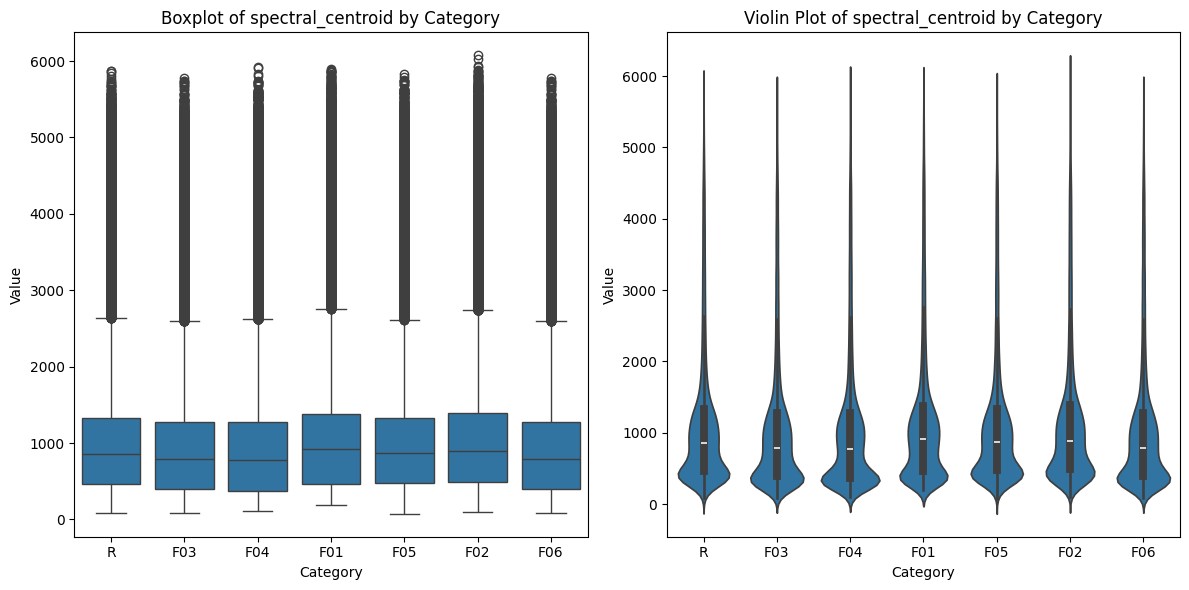

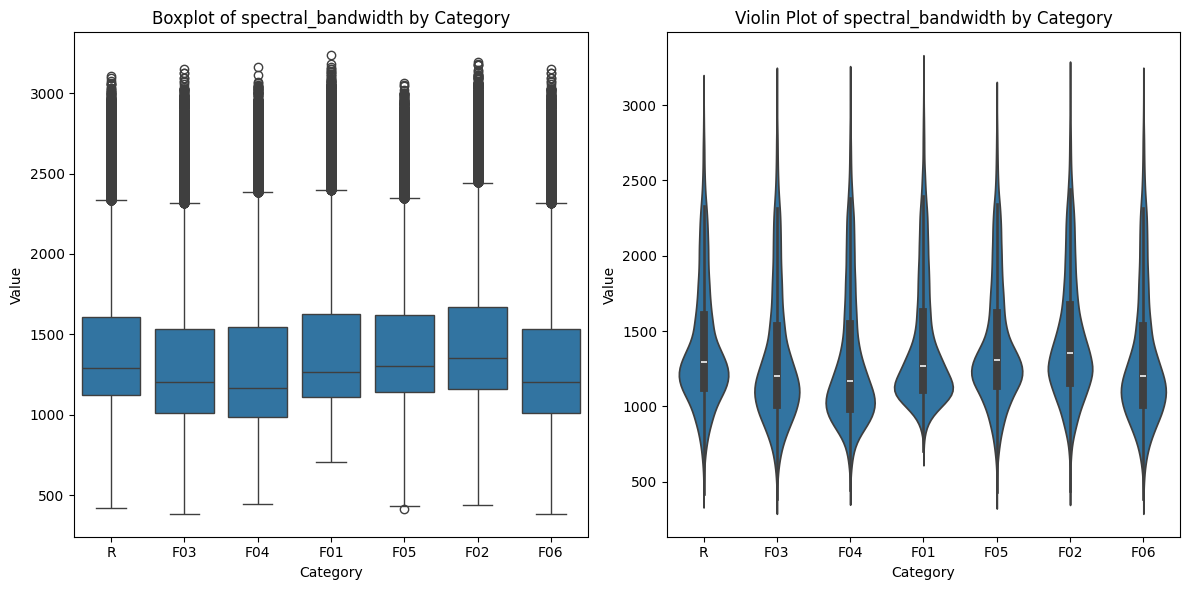

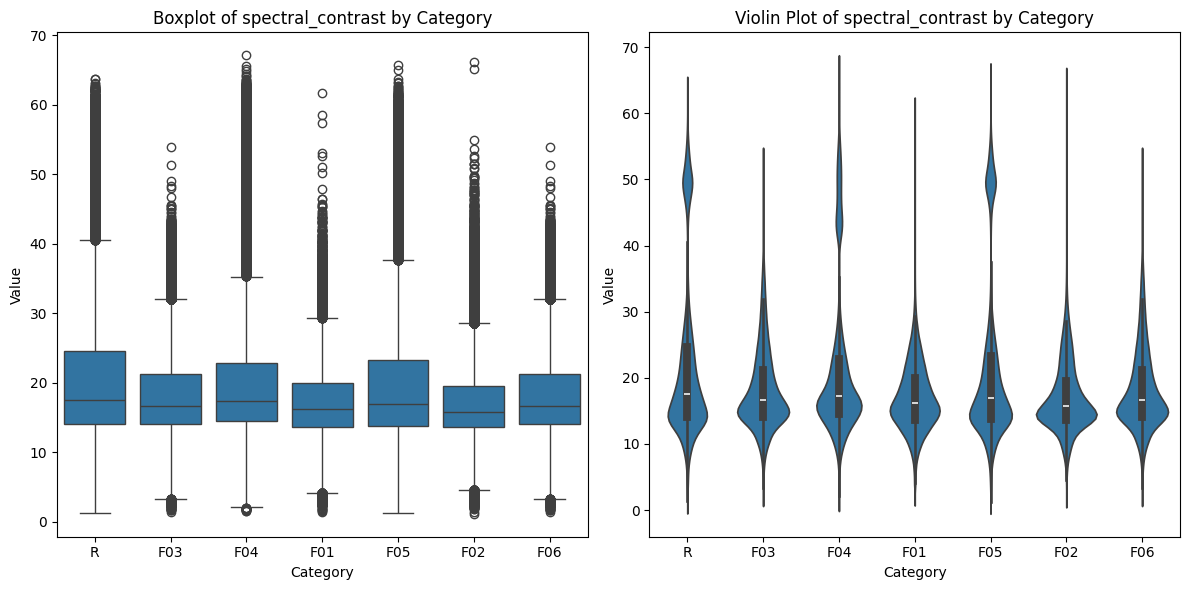

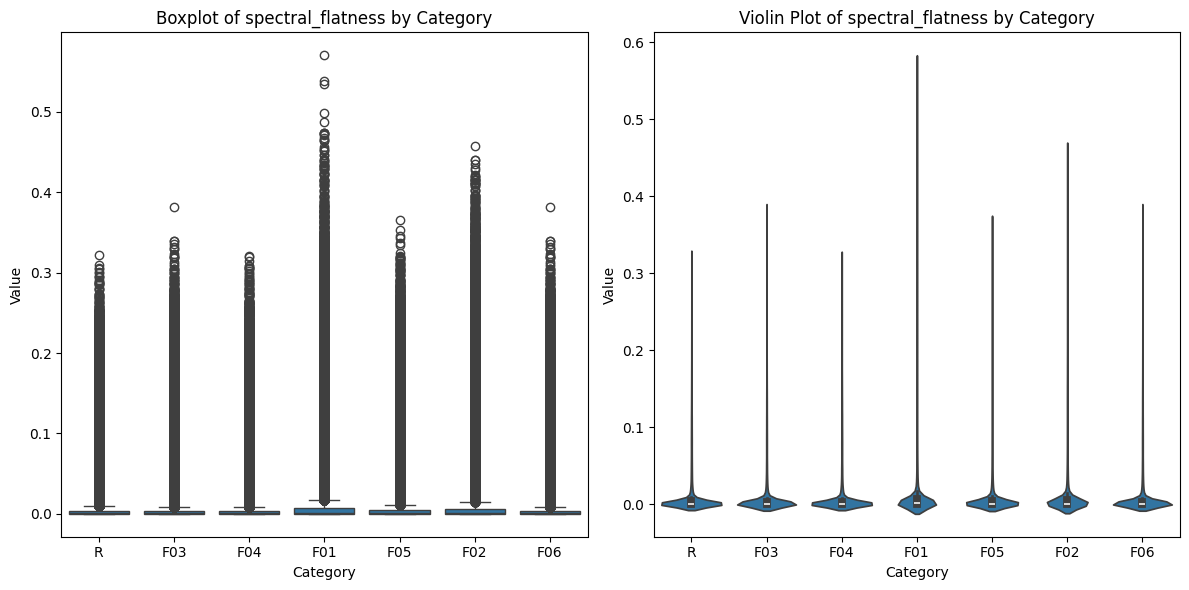

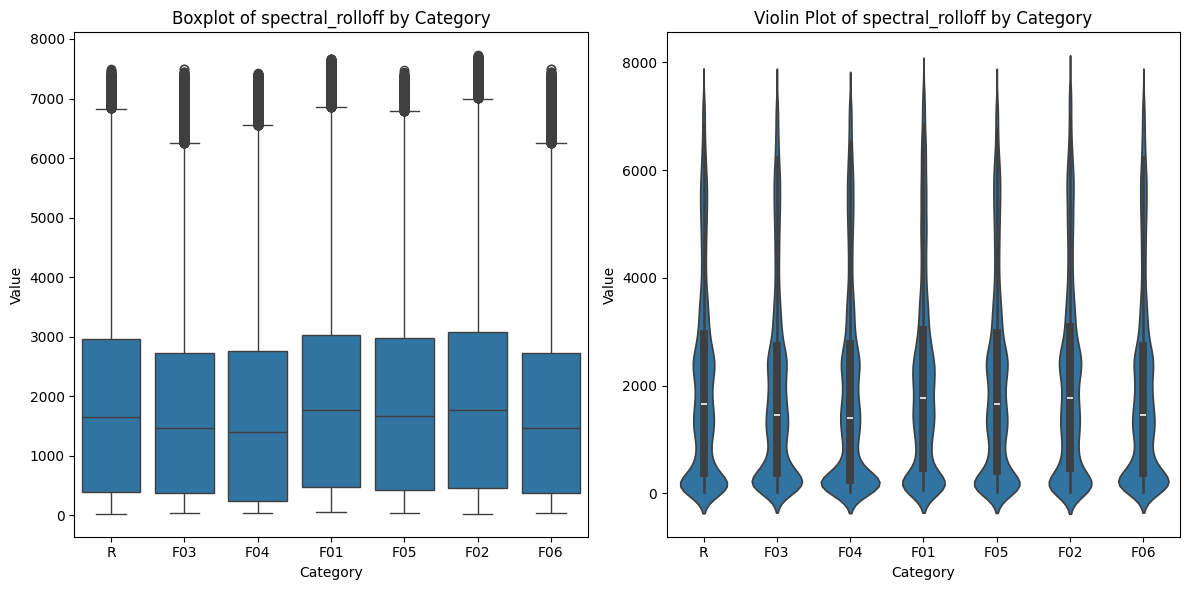

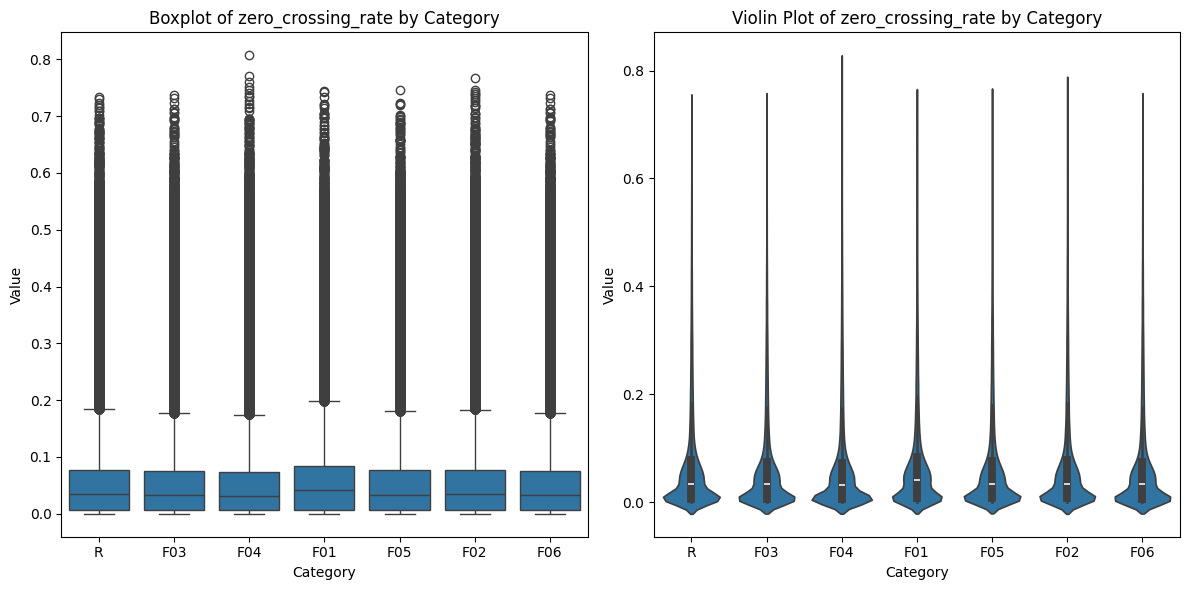

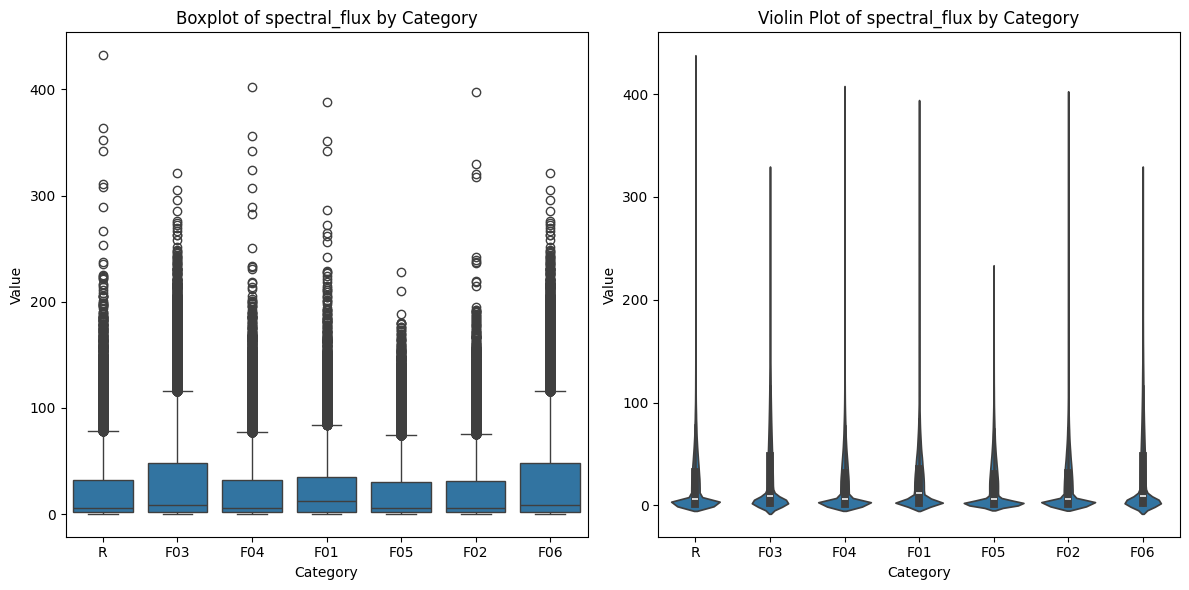

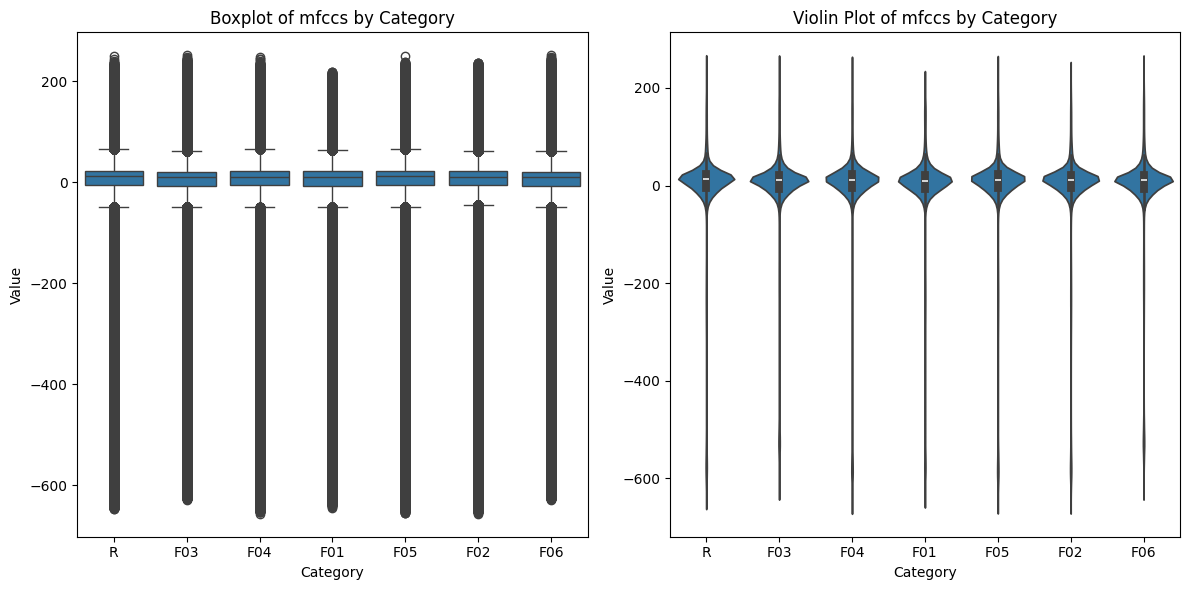

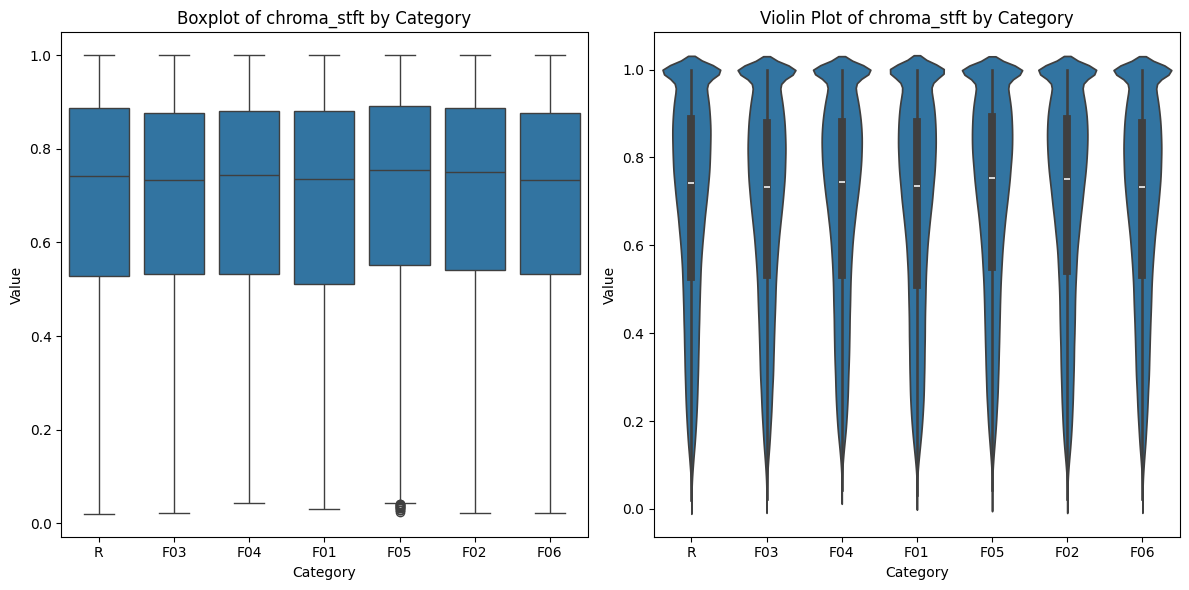

In [33]:
def plot_feature_distributions(df, feature_name):
    plot_data = []
    categories = []

    for idx, row in df.iterrows():
        feature_array = row[feature_name]
        real_or_fake = row['real_or_fake']
        plot_data.extend(feature_array)
        categories.extend([real_or_fake] * len(feature_array))

    plot_df = pd.DataFrame({
        'value': plot_data,
        'category': categories
    })

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='category', y='value', data=plot_df)
    plt.title(f'Boxplot of {feature_name} by Category')
    plt.xlabel('Category')
    plt.ylabel('Value')

    plt.subplot(1, 2, 2)
    sns.violinplot(x='category', y='value', data=plot_df)
    plt.title(f'Violin Plot of {feature_name} by Category')
    plt.xlabel('Category')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()


low_level_feature_df = pd.DataFrame(low_level_features)
for feature in ['spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate', 'spectral_flux', 'mfccs', 'chroma_stft']:
    plot_feature_distributions(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [34]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [45]:
def compute_high_level_features(feature_dict):
    features = {
        'audio_id': feature_dict['audio_id'],
        'real_or_fake': feature_dict['real_or_fake']
    }

    # Statistical Measures
    for feature_name in ['spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
                         'spectral_flatness', 'spectral_rolloff', 'zero_crossing_rate', 
                         'spectral_flux']:
        feature_array = feature_dict[feature_name]
        features[f'{feature_name}_mean'] = np.mean(feature_array)
        features[f'{feature_name}_std'] = np.std(feature_array)
        features[f'{feature_name}_var'] = np.var(feature_array)
        features[f'{feature_name}_min'] = np.min(feature_array)
        features[f'{feature_name}_max'] = np.max(feature_array)
        features[f'{feature_name}_range'] = np.max(feature_array) - np.min(feature_array)
        features[f'{feature_name}_skew'] = skew(feature_array)
        features[f'{feature_name}_kurtosis'] = kurtosis(feature_array)
        features[f'{feature_name}_25th_percentile'] = np.percentile(feature_array, 25)
        features[f'{feature_name}_50th_percentile'] = np.percentile(feature_array, 50)  # Median
        features[f'{feature_name}_75th_percentile'] = np.percentile(feature_array, 75)

    # MFCCs
    mfccs = feature_dict['mfccs'].reshape(-1, 13)  # Reshape the flattened array to its original form
    for i in range(mfccs.shape[1]):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[:, i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[:, i])
        features[f'mfcc_{i+1}_min'] = np.min(mfccs[:, i])
        features[f'mfcc_{i+1}_max'] = np.max(mfccs[:, i])
        features[f'mfcc_{i+1}_range'] = np.max(mfccs[:, i]) - np.min(mfccs[:, i])
        features[f'mfcc_{i+1}_skew'] = skew(mfccs[:, i])
        features[f'mfcc_{i+1}_kurtosis'] = kurtosis(mfccs[:, i])
        features[f'mfcc_{i+1}_25th_percentile'] = np.percentile(mfccs[:, i], 25)
        features[f'mfcc_{i+1}_50th_percentile'] = np.percentile(mfccs[:, i], 50)  # Median
        features[f'mfcc_{i+1}_75th_percentile'] = np.percentile(mfccs[:, i], 75)

    # Chroma Features
    chroma = feature_dict['chroma_stft'].reshape(-1, 12)  # Reshape the flattened array to its original form
    for i in range(chroma.shape[1]):
        features[f'chroma_{i+1}_mean'] = np.mean(chroma[:, i])
        features[f'chroma_{i+1}_std'] = np.std(chroma[:, i])
        features[f'chroma_{i+1}_min'] = np.min(chroma[:, i])
        features[f'chroma_{i+1}_max'] = np.max(chroma[:, i])
        features[f'chroma_{i+1}_range'] = np.max(chroma[:, i]) - np.min(chroma[:, i])
        features[f'chroma_{i+1}_skew'] = skew(chroma[:, i])
        features[f'chroma_{i+1}_kurtosis'] = kurtosis(chroma[:, i])
        features[f'chroma_{i+1}_25th_percentile'] = np.percentile(chroma[:, i], 25)
        features[f'chroma_{i+1}_50th_percentile'] = np.percentile(chroma[:, i], 50)  # Median
        features[f'chroma_{i+1}_75th_percentile'] = np.percentile(chroma[:, i], 75)

    return features


def high_level_feature_generator(low_level_gen):
    for low_level_features in low_level_gen:
        yield compute_high_level_features(low_level_features)

In [46]:
low_level_gen = low_level_feature_generator(df)
high_level_features = list(high_level_feature_generator(low_level_gen))
high_level_feature_df = pd.DataFrame(high_level_features)

Processing Audios: 100%|██████████| 3500/3500 [02:34<00:00, 22.66it/s]


In [47]:
high_level_feature_df

,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_skew,spectral_centroid_kurtosis,...,chroma_12_mean,chroma_12_std,chroma_12_min,chroma_12_max,chroma_12_range,chroma_12_skew,chroma_12_kurtosis,chroma_12_25th_percentile,chroma_12_50th_percentile,chroma_12_75th_percentile
0,p225_002,R,1407.277479,1139.511158,1.298486e+06,273.979621,4860.736866,4586.757245,1.463122,1.420546,...,0.635642,0.249358,0.093912,1.0,0.906088,-0.385903,-0.885308,0.446530,0.664310,0.840043
1,p225_002,F03,1269.150323,1085.214354,1.177690e+06,319.092868,4752.988182,4433.895314,1.698507,2.176611,...,0.667533,0.264246,0.084627,1.0,0.915373,-0.691812,-0.673039,0.514377,0.744306,0.866197
2,p225_002,F04,1336.049769,1171.331560,1.372018e+06,247.256673,4922.406802,4675.150129,1.538783,1.646514,...,0.659931,0.258647,0.086858,1.0,0.913142,-0.669305,-0.628815,0.512689,0.726731,0.857400
3,p225_002,F01,1540.345739,1212.507952,1.470176e+06,257.468837,5074.111834,4816.642997,1.391513,1.066186,...,0.676746,0.277552,0.049766,1.0,0.950234,-0.697709,-0.761657,0.445795,0.762157,0.912362
4,p225_002,F05,1414.717840,1149.669533,1.321740e+06,295.103707,4982.683428,4687.579722,1.570971,1.777596,...,0.643502,0.238275,0.092679,1.0,0.907321,-0.404826,-0.742693,0.498929,0.660084,0.839168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,p227_037,R,1552.956324,999.075044,9.981509e+05,388.172970,4600.922167,4212.749197,1.549436,1.520999,...,0.705774,0.202020,0.187959,1.0,0.812041,-0.436561,-0.652879,0.547622,0.711580,0.868450
3496,p227_037,F05,1576.434714,984.655802,9.695470e+05,498.677006,4551.413890,4052.736884,1.543854,1.444447,...,0.728138,0.195133,0.253553,1.0,0.746447,-0.354435,-0.898639,0.558851,0.740566,0.915889
3497,p227_037,F01,1664.541240,1019.091773,1.038548e+06,363.770847,4487.643623,4123.872775,1.265545,0.759631,...,0.714879,0.223142,0.173859,1.0,0.826141,-0.587084,-0.682671,0.523312,0.763470,0.872645
3498,p227_037,F06,1420.889072,1039.009012,1.079540e+06,323.817544,4574.689581,4250.872037,1.495226,1.367341,...,0.712014,0.186165,0.229798,1.0,0.770202,-0.090366,-0.664192,0.582743,0.702582,0.834114


In [49]:
def perform_statistical_tests(df, target_column='real_or_fake'):
    real_data = df[df[target_column] == 'R']
    fake_data = df[df[target_column] != 'R']

    results = []

    for column in df.columns:
        if column not in ['audio_id', 'real_or_fake']:
            t_stat, t_p_val = ttest_ind(real_data[column], fake_data[column], equal_var=False)
            u_stat, u_p_val = mannwhitneyu(real_data[column], fake_data[column])
            effect_size = (real_data[column].mean() - fake_data[column].mean()) / np.sqrt((real_data[column].var() + fake_data[column].var()) / 2)
            f_stat, f_p_val = f_oneway(real_data[column], fake_data[column])

            results.append({
                'feature': column,
                't_stat': t_stat,
                't_p_val': t_p_val,
                'u_stat': u_stat,
                'u_p_val': u_p_val,
                'effect_size': effect_size,
                'f_stat': f_stat,
                'f_p_val': f_p_val
            })

    results_df = pd.DataFrame(results)
    return results_df

In [50]:
# Perform statistical tests
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

/usr/local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_31188/1246871530.py:21: RuntimeWarning: invalid value encountered in scalar divide
  effect_size = (real_data[column].mean() - fake_data[column].mean()) / np.sqrt((real_data[column].var() + fake_data[column].var()) / 2)
/usr/local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
0,spectral_centroid_mean,1.369696,0.171224,781180.0,0.136105,0.065041,1.753959,0.185466
1,spectral_centroid_std,-0.722790,0.470057,734608.0,0.461883,-0.034807,0.516058,0.472576
2,spectral_centroid_var,-0.764145,0.445045,734608.0,0.461883,-0.036664,0.568492,0.450909
3,spectral_centroid_min,2.738781,0.006318,835249.0,0.000046,0.126855,6.382160,0.011571
4,spectral_centroid_max,0.114091,0.909199,752626.0,0.900124,0.005457,0.012513,0.910938
...,...,...,...,...,...,...,...,...
322,chroma_12_skew,-2.079152,0.037982,708619.0,0.047919,-0.100771,4.381716,0.036398
323,chroma_12_kurtosis,1.115549,0.265018,775310.0,0.226335,0.054457,1.298599,0.254547
324,chroma_12_25th_percentile,-0.825067,0.409626,733160.0,0.420839,-0.039988,0.689928,0.406246
325,chroma_12_50th_percentile,0.413057,0.679696,758204.0,0.694950,0.019968,0.171160,0.679108


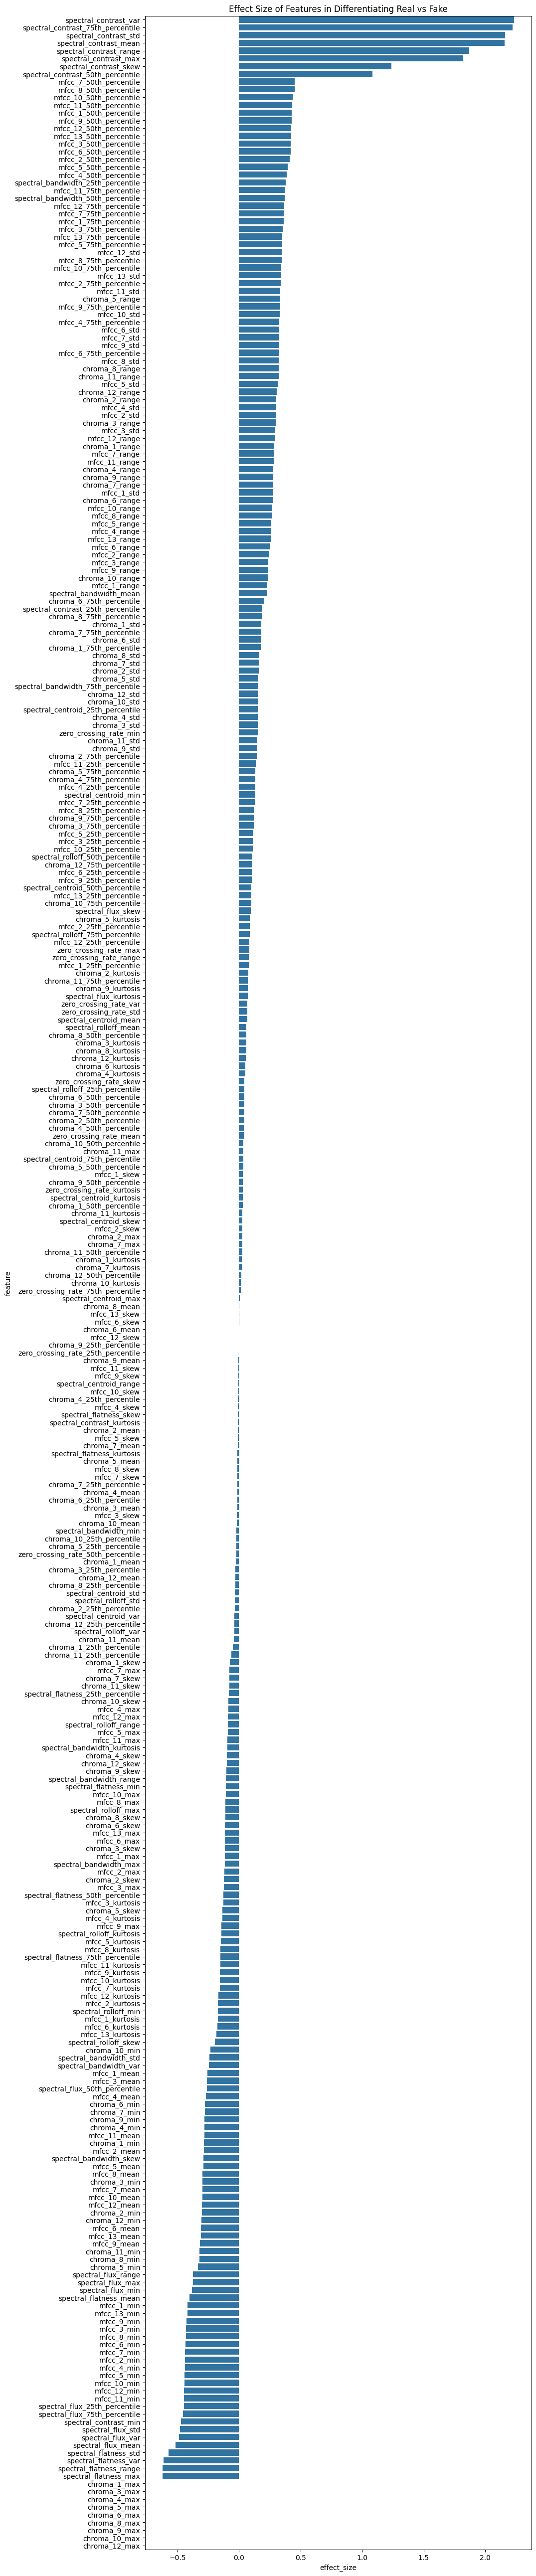

In [54]:
# Visualize the results
plt.figure(figsize=(10, 66))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

In [100]:
stats_df[stats_df['feature'] == 'spectral_contrast_kurtosis']

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
29,spectral_contrast_kurtosis,-0.34062,0.733417,737049.0,0.535874,-0.010424,0.029126,0.864498


In [76]:
stats_df.sort_values(by=['effect_size'], ascending=False).iloc[:30, :]

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
24,spectral_contrast_var,83.813610,0.000000e+00,1356338.0,1.036661e-184,2.234207,1261.479292,3.216409e-236
32,spectral_contrast_75th_percentile,53.308802,1.655510e-279,1413794.0,5.831359e-221,2.224501,1691.339834,6.066503e-302
23,spectral_contrast_std,82.393662,0.000000e+00,1356338.0,1.036661e-184,2.161240,1173.737869,4.493503e-222
22,spectral_contrast_mean,68.841705,0.000000e+00,1382434.0,9.055327e-201,2.159630,1266.255656,5.557458e-237
27,spectral_contrast_range,64.195347,0.000000e+00,1272959.0,6.327009e-138,1.872522,918.688968,2.172698e-179
26,spectral_contrast_max,63.988851,0.000000e+00,1247214.0,7.165938e-125,1.822901,861.769335,1.587410e-169
28,spectral_contrast_skew,43.533796,0.000000e+00,1052800.0,1.755523e-47,1.237709,396.951846,9.494532e-84
31,spectral_contrast_50th_percentile,21.315255,2.831265e-76,1167485.0,1.310181e-88,1.082942,562.400436,2.052984e-115
145,mfcc_7_50th_percentile,9.262329,2.691950e-19,970669.0,5.163334e-26,0.450962,88.568962,8.627234e-21
155,mfcc_8_50th_percentile,9.259611,2.738826e-19,972642.0,1.884227e-26,0.450175,87.996060,1.144346e-20


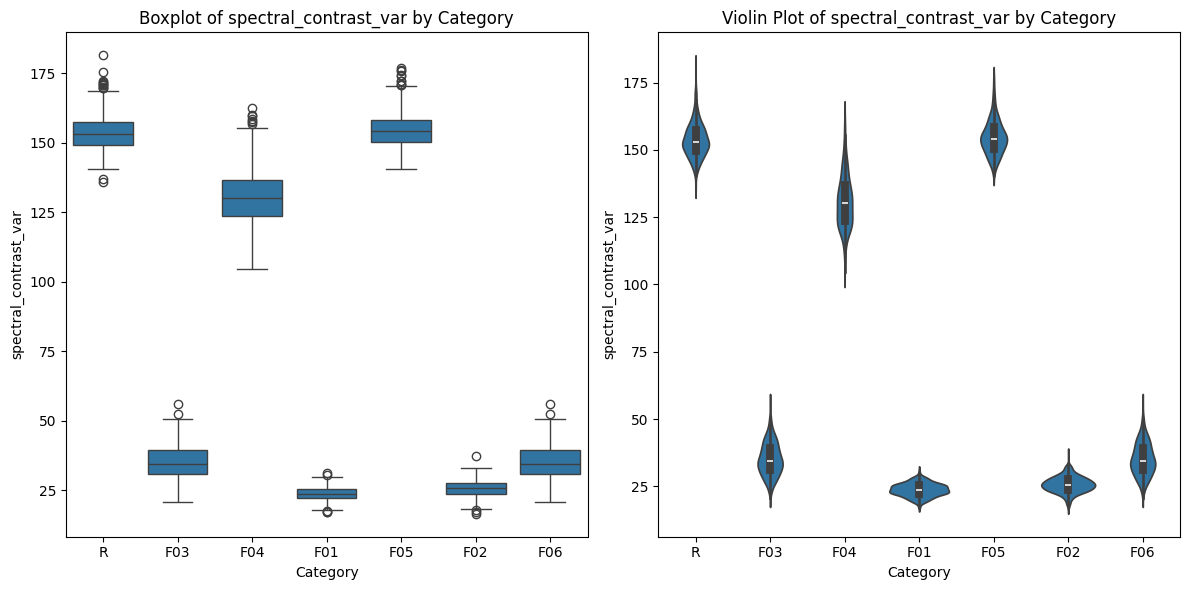

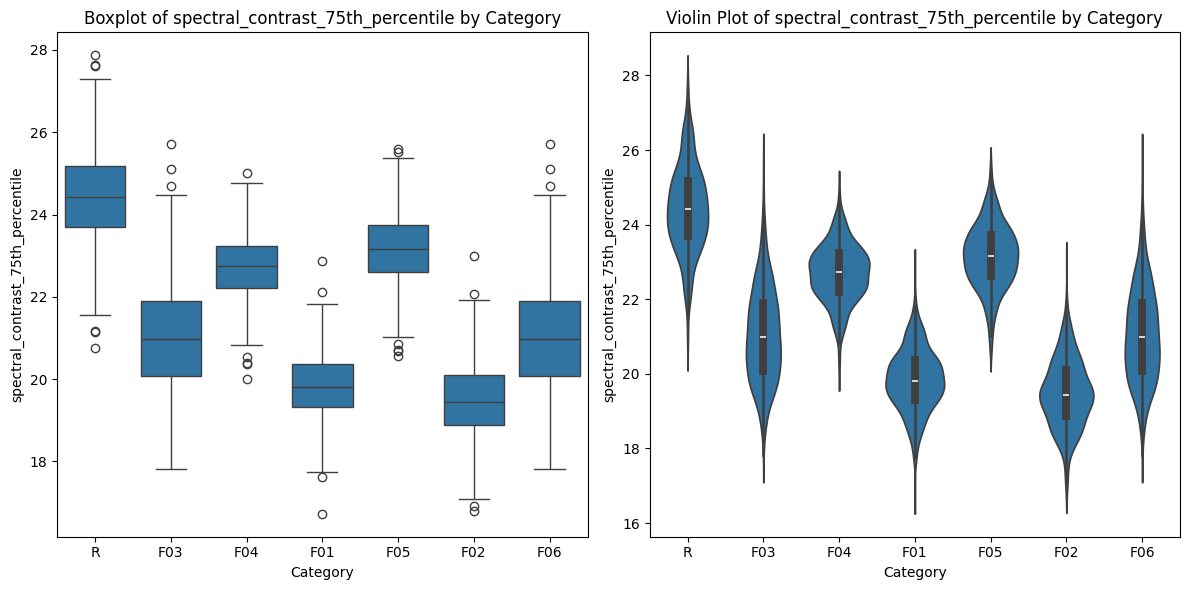

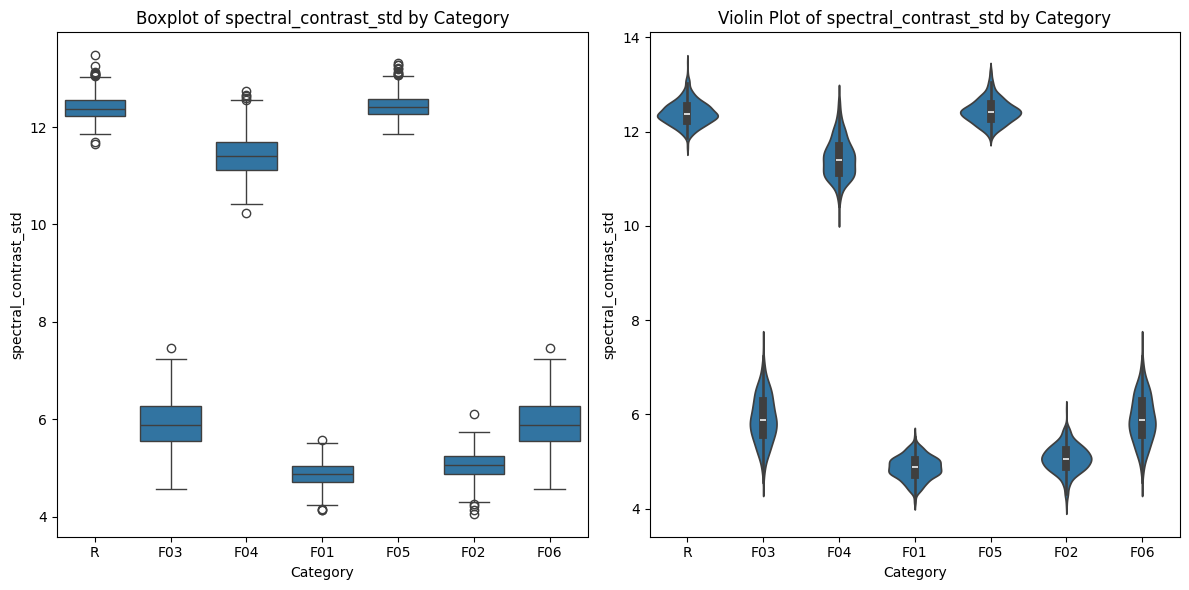

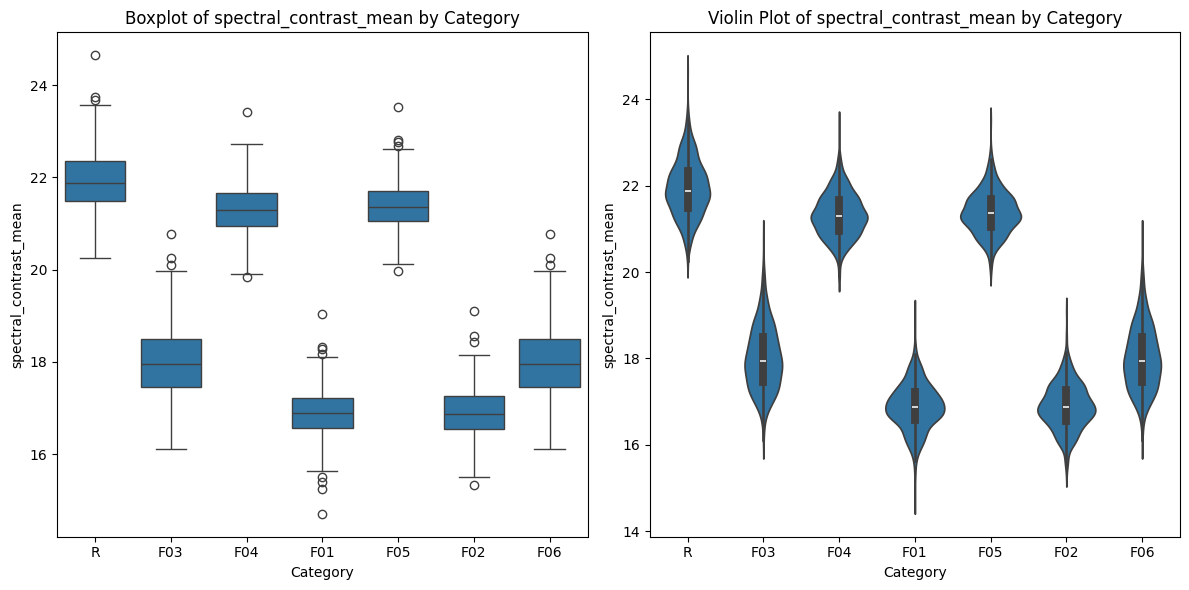

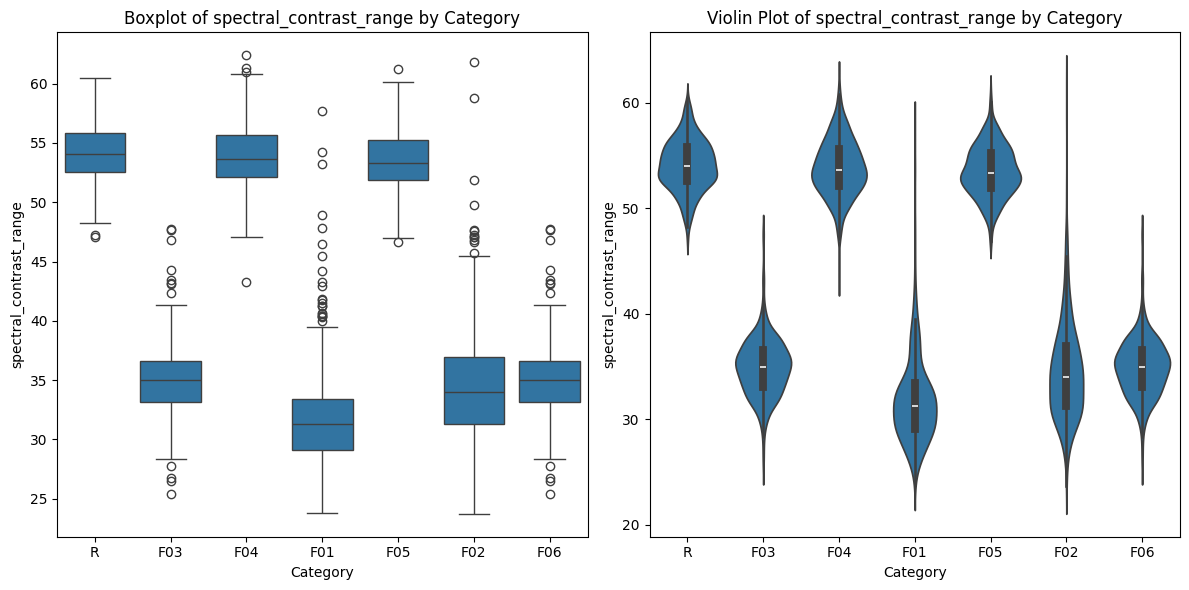

In [113]:
def plot_selected_feature_distributions(df, feature_list, target_column='real_or_fake'):
    """
    Plots the distribution of selected high-level features across different real_or_fake categories.

    Parameters:
    df (pd.DataFrame): DataFrame containing high-level features.
    feature_list (list): List of feature names to plot.
    target_column (str): Name of the target column. Default is 'real_or_fake'.
    """
    for feature in feature_list:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        sns.boxplot(x=target_column, y=feature, data=df)
        plt.title(f'Boxplot of {feature} by Category')
        plt.xlabel('Category')
        plt.ylabel(feature)

        plt.subplot(1, 2, 2)
        sns.violinplot(x=target_column, y=feature, data=df)
        plt.title(f'Violin Plot of {feature} by Category')
        plt.xlabel('Category')
        plt.ylabel(feature)

        plt.tight_layout()
        plt.show()

all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_selected_feature_distributions(high_level_feature_df, all_features[:5])

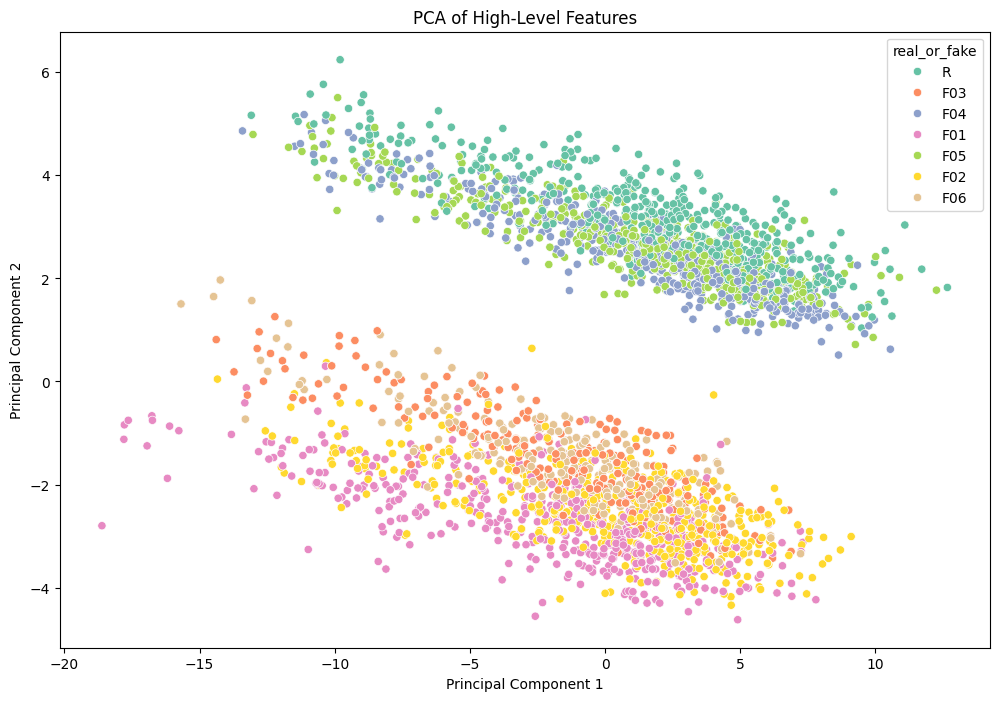

In [115]:
def perform_pca_and_plot(df, selected_features, target_column='real_or_fake'):
    # Standardize the features
    features = df[selected_features]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)
    
    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df[target_column] = df[target_column].values

    # Plot the PCA results
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue=target_column, data=pca_df, palette='Set2')
    plt.title('PCA of High-Level Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title=target_column)
    plt.show()

perform_pca_and_plot(high_level_feature_df, all_features[:40])

In [116]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    
    X = df[selected_features]
    y = df[target_column].apply(lambda x: 1 if x == 'R' else 0)

    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    
    model = LogisticRegression()
    model.fit(X_scaled, y)

    
    feature_importances = model.coef_[0]

    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feature,importance
1,spectral_contrast_75th_percentile,2.819743
3,spectral_contrast_mean,2.277779
7,spectral_contrast_50th_percentile,2.081376
0,spectral_contrast_var,1.868443
144,zero_crossing_rate_mean,1.825607
...,...,...
250,spectral_flatness_75th_percentile,-1.208118
78,chroma_1_std,-1.214579
315,spectral_flatness_var,-1.328563
6,spectral_contrast_skew,-1.572897


### Redundant Features

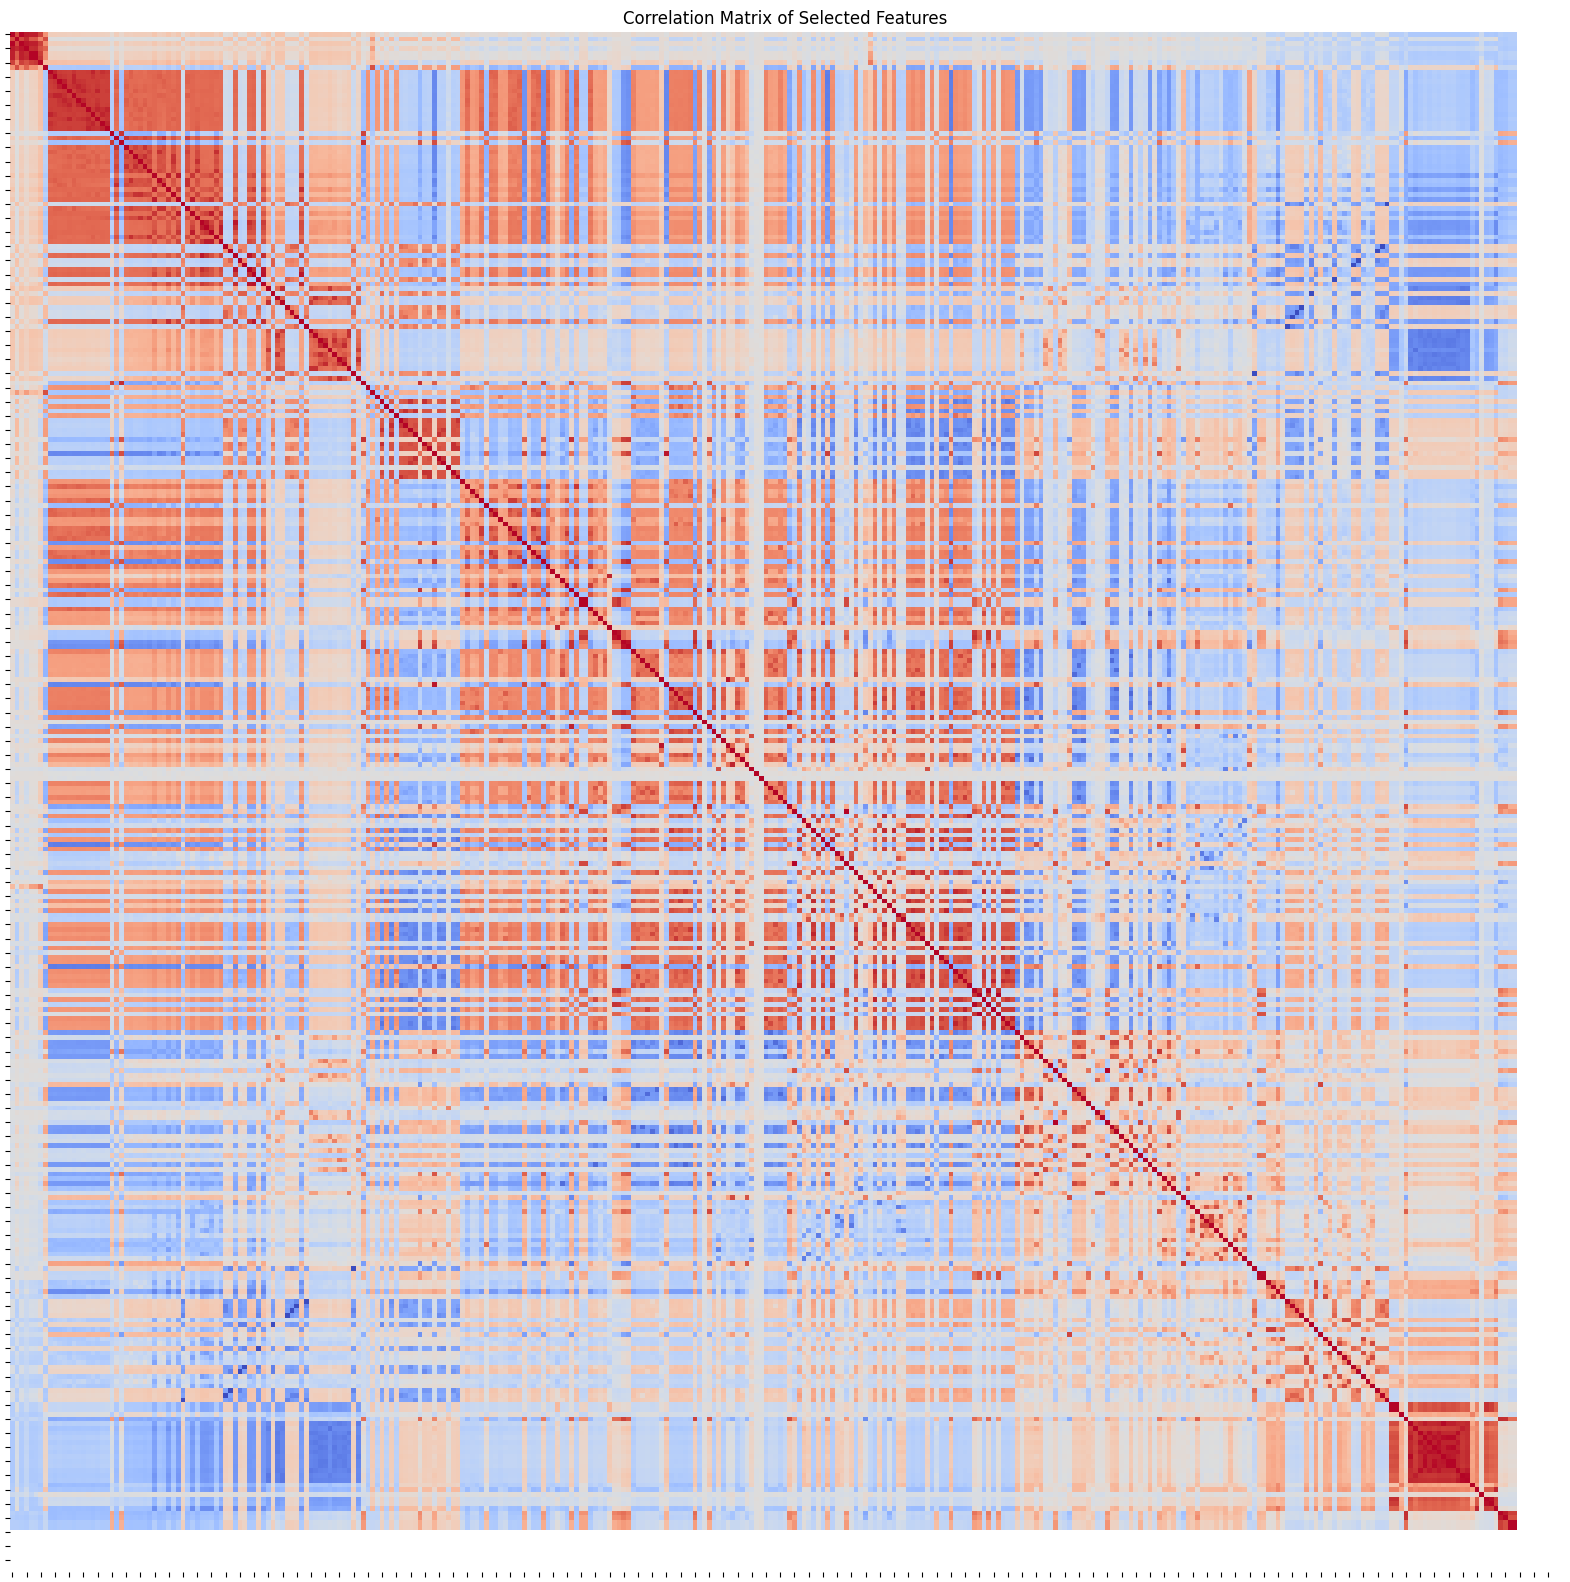

In [120]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [121]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['spectral_contrast_var', 'mfcc_7_50th_percentile', 'spectral_bandwidth_25th_percentile', 'chroma_5_range', 'chroma_8_range', 'mfcc_12_range', 'chroma_6_75th_percentile', 'chroma_8_75th_percentile', 'chroma_1_75th_percentile', 'zero_crossing_rate_min', 'chroma_12_75th_percentile', 'spectral_flux_skew', 'zero_crossing_rate_max', 'zero_crossing_rate_skew', 'chroma_11_max', 'mfcc_1_skew', 'chroma_2_max', 'chroma_7_max', 'mfcc_6_skew', 'mfcc_9_skew', 'mfcc_4_skew', 'spectral_bandwidth_min', 'mfcc_12_max', 'mfcc_11_mean', 'spectral_flux_min', 'spectral_contrast_min', 'chroma_1_max', 'chroma_3_max', 'chroma_4_max', 'chroma_5_max', 'chroma_6_max', 'chroma_8_max', 'chroma_9_max', 'chroma_10_max', 'chroma_12_max']


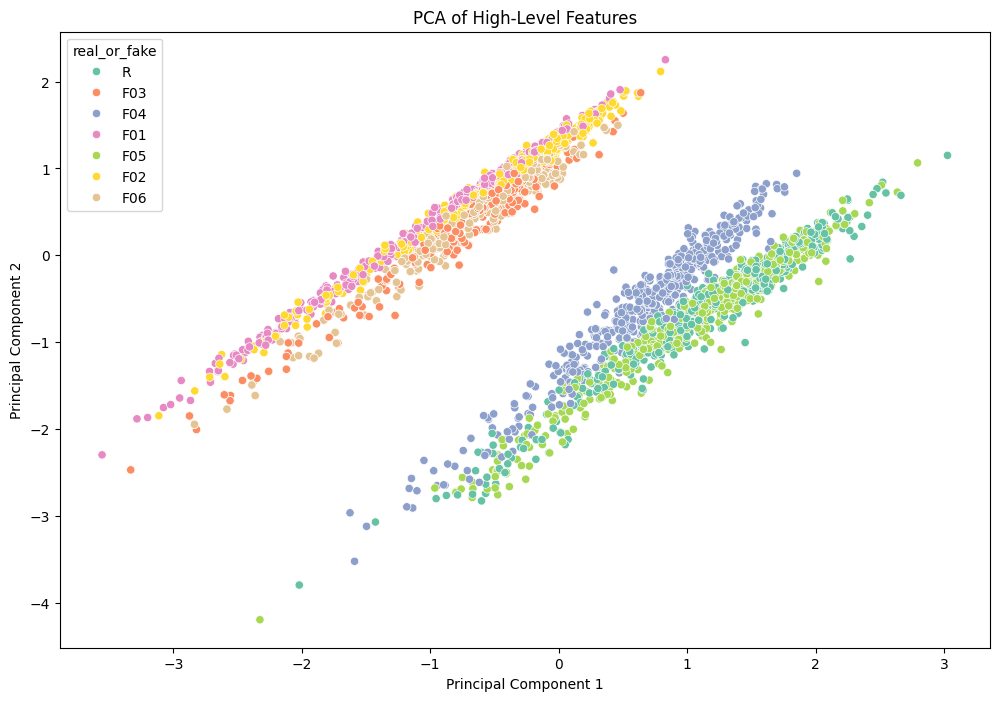

In [127]:
perform_pca_and_plot(high_level_feature_df, reduced_features[:2])

In [129]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features[:2])
importance_df

,feature,importance
0,spectral_contrast_var,4.560466
1,mfcc_7_50th_percentile,0.367813


### Baseline Model

In [130]:
good_features = reduced_features[:2]

In [131]:
X = high_level_feature_df[good_features]
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


Model: Logistic Regression
Accuracy: 0.8529
Precision: 0.5636
Recall: 0.2818
F1 Score: 0.3758
Classification Report:
               precision    recall  f1-score   support

        Fake       0.88      0.96      0.92       590
        Real       0.56      0.28      0.38       110

    accuracy                           0.85       700
   macro avg       0.72      0.62      0.65       700
weighted avg       0.83      0.85      0.83       700

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8400
Precision: 0.4898
Recall: 0.4364
F1 Score: 0.4615
Classification Report:
               precision    recall  f1-score   support

        Fake       0.90      0.92      0.91       590
        Real       0.49      0.44      0.46       110

    accuracy                           0.84       700
   macro avg       0.69      0.68      0.68       700
weighted avg       0.83      0.84      0.84       700

-------------------------------------------------------